In [1]:
!conda env list

# conda environments:
#
tf2                      D:\ProgramData\Anaconda3\envs\tf2
base                     d:\ProgramData\Anaconda3
tf2                   *  d:\ProgramData\Anaconda3\envs\tf2



In [2]:
import warnings
import numpy as np
import pandas as pd


from math import sqrt

import matplotlib.pyplot as plt
from numpy import vectorize

from numpy import concatenate

from sklearn.metrics import mean_squared_error, explained_variance_score, max_error, mean_absolute_error, mean_squared_log_error, median_absolute_error, mean_absolute_percentage_error, r2_score, mean_poisson_deviance, mean_gamma_deviance, mean_tweedie_deviance  

from tensorflow.keras.models import Sequential

from tensorflow.keras import optimizers
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten

from numpy.random import seed


import tensorflow as tf

In [3]:

#Función para escalar los datos, recibe dato a escalar (vector), minimo y maximo 
def escala(x,mi,ma):
    return (x-mi)/(ma-mi)

escalador = vectorize(escala)

#Ejemplo de uso
#   values[:,0]=escalador(values[:,0],0,300)

def Reescala(x,mi,ma):
    return x*(ma-mi)+mi

Reescalador = vectorize(Reescala)


In [4]:
def evalua_error(y_re, y_pr):
    y_re1 = y_re.reshape((len(y_re)))
    y_pr1 = y_pr.reshape((len(y_re)))
    y_re_mod = y_re1
    y_pr_mod = y_pr1
    
    y_re_mod[y_re_mod==0]=1
    y_pr_mod[y_pr_mod==0]=1
    MAD = 0
    CFE = 0
    MSE = 0
    MAPE = 0
    for i in range (0,len(x_pron)):
        CFE = CFE + (y_re1[i] - y_pr1[i])
        MAD = MAD + abs(y_re1[i] - y_pr1[i])
        MSE = MSE + (y_re1[i] - y_pr1[i])*(y_re1[i] - y_pr1[i])
        MAPE = MAPE + 100*(y_re_mod[i] - y_pr_mod[i])/y_re_mod[i] 
    MAD = MAD/len(y_re1)
    MSE = MSE/len(y_re1)
    RMSE = np.sqrt(MSE)
    MAPE = MAPE/len(y_re1)
    VARIANZA_EXPLICADA = explained_variance_score(y_re, y_pr)
    ERROR_RESIDUAL_MAXIMO = max_error(y_re, y_pr)
    MEDIA_ERROR_ABSOLUTO = mean_absolute_error(y_re, y_pr)
    
    ERROR_CUADRATICO_MEDIO = mean_squared_error(y_re, y_pr)
    ERROR_CUADRATICO_LOGARITMICO = 1  #mean_squared_log_error(y_re_mod, y_pr_mod)
    MEDIA_ERROR_ABSOLUTO = median_absolute_error(y_re, y_pr)
    ERROR_PORCENTUAL_ABSOLUTO = mean_absolute_percentage_error(y_re, y_pr)
    COEFICIENTE_DETERMINACION_R2 = r2_score(y_re, y_pr)
    DESVIACION_POISSON = 1 #mean_poisson_deviance(y_re, y_pr)
    DESVIACION_GAMMA = 1 #mean_gamma_deviance(y_re_mod, y_pr_mod)
    DESVIACION_TWEEDIE = 1 #mean_tweedie_deviance(y_re, y_pr)
    return [CFE, MAD, MSE, RMSE, MAPE, VARIANZA_EXPLICADA, 
            ERROR_RESIDUAL_MAXIMO, MEDIA_ERROR_ABSOLUTO, ERROR_CUADRATICO_MEDIO, 
            ERROR_CUADRATICO_LOGARITMICO, MEDIA_ERROR_ABSOLUTO, ERROR_PORCENTUAL_ABSOLUTO, 
            COEFICIENTE_DETERMINACION_R2, DESVIACION_POISSON, DESVIACION_GAMMA, DESVIACION_TWEEDIE]



In [5]:
Ciudad = 'CALI'
PATH = 'D:/DENGUE_CODIGO/' + Ciudad + '/RESULTADOS/'
csv_path_x = PATH + 'Set_datos_X10.csv'
csv_path_y = PATH + 'Set_datos_Y10.csv'


dx = pd.read_csv(csv_path_x, index_col=False)

dx = dx.drop(dx.columns[[0]], axis='columns')

dy = pd.read_csv(csv_path_y, index_col=False)
dy = dy.drop(dy.columns[[0]], axis='columns')
dx.head()


valx = dx.values
valy = dy.values
# print(valx)
# print(valy)

semanas_pronostico = 8


In [6]:
#Crear una matriz con los limites para el esclalado de los datos
limites=np.array(([np.amin(valx[:,0])],[np.amax(valx[:,0])]))

for i in range(1,len(valx[1,:])):
    limites=np.insert(limites, limites.shape[1], [np.amin(valx[:,i]), np.amax(valx[:,i])], axis=1)


In [7]:
# ventana_pronostico = 2
x = np.zeros((len(valx), len(valx[0])))
for i in range(0,len(valx[1,:])):
    x[:,i]=escalador(valx[:,i],limites[0][i],limites[1][i])

y = escalador(valy,np.amin(valy),np.amax(valy))
y= np.array(y).reshape(-1)
valy= np.array(valy).reshape(-1)
print(np.amin(valy), np.amax(valy))

#y = y[1:]
#x= x[:-1,:]




print(x.shape)
# print(x)
print(y.shape)
# print(y)

8 834
(624, 144)
(624,)


In [8]:
#Numero de datos para el pronostico, se tomaran los ultimos
ventana = 8

total = len(valy) - ventana
n_pronostico = total-int(0.95*total)

#Numero de datos para el entrenamiento
n_train = int(0.7*total)

#Numero de datos para test
n_test = total - n_train - n_pronostico

#print("Cantidad total de datos = ",len(endog_y),"\nNumero de datos para pronostico = ", n_pronostico,"\nNumero de datos para entrenamiento = ",n_train,"\nNumero de datos para test = ",n_test)

print(n_pronostico,n_train,n_test)

shift=0

x_train = x[0:n_train,:]
x_test = x[n_train:n_train+n_test,:]
x_pron = x[n_train+n_test:n_train+n_test+n_pronostico,:]

y_train = y[:n_train+shift]

y_test = y[n_train+shift:n_train+n_test+shift]
y_test_inv = valy[n_train+shift:n_train+n_test+shift]

y_pron = y[n_train+n_test+shift:n_train+n_test+n_pronostico+shift]
y_pron_inv = valy[n_train+n_test+shift:n_train+n_test+n_pronostico+shift]
print(x_train.shape,x_test.shape,x_pron.shape,y_train.shape,y_test.shape,y_pron.shape)

# print(x_train)





# # reshape input to be 3D [samples, timesteps, features]
x_trainMLP = x_train
y_trainMLP = y_train
x_testMLP = x_test
y_testMLP = y_test
x_pronMLP = x_pron
y_pronMLP = y_pron

x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
# test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

x_pron = x_pron.reshape((x_pron.shape[0], 1, x_pron.shape[1]))

Er = np.zeros([9,16])
Er_t = ['CFE', 'MAD', 'MSE', 'RMSE', 'MAPE', 'Varianza explicada', 'Error residual máximo', 'Error absoluto medio', 'Error cuadrático medio',
       'Error cuadrático logarítmico medio', 'Mediana del error absoluto', 'Error porcentual absoluto medio', 'R^2 (Coeficiente de determinación)',
       'Desviación de Poisson media', 'Desviación Gamma media', 'Desviación Tweedie media']


31 431 154
(431, 144) (154, 144) (31, 144) (431,) (154,) (31,)


In [9]:
from itertools import islice

def window(seq, n=2):
    "Returns a sliding window (of width n) over data from the iterable"
    "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result

#[print(list(i)) for i in list(window(y_pron_inv,2))];


In [10]:
def data_gen(shift=2, cnn=False, mix=False):

    total = len(valy) - shift
    n_pronostico = shift

    #Numero de datos para el entrenamiento
    n_train = int(0.7*total)

    #Numero de datos para test
    n_test = total - n_train - n_pronostico

    #print("Cantidad total de datos = ",len(endog_y),"\nNumero de datos para pronostico = ", n_pronostico,"\nNumero de datos para entrenamiento = ",n_train,"\nNumero de datos para test = ",n_test)

    #print(n_pronostico,n_train,n_test)

    y_win= np.array(list(window(y,shift)))
    valy_win =np.array(list(window(valy,shift)))

    x_train = x[0:n_train,:]
    x_test = x[n_train:n_train+n_test,:]
    x_pron = x[n_train+n_test:n_train+n_test+n_pronostico,:]

    y_train = y_win[:n_train,:]

    y_test = y_win[n_train:n_train+n_test,:]
    y_test_inv = valy_win[n_train:n_train+n_test]

    y_pron = y_win[n_train+n_test:n_train+n_test+n_pronostico]
    y_pron_inv = valy_win[n_train+n_test:n_train+n_test+n_pronostico]
    #print(x_train.shape,x_test.shape,x_pron.shape,y_train.shape,y_test.shape,y_pron.shape)

#     print(x_train)
#     print('\n\n','y','\n\n')
#     print(y_train)

    
    
    
    x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
    # test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

    x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

    x_pron = x_pron.reshape((x_pron.shape[0], 1, x_pron.shape[1]))
    
    
    if cnn:
        x_train = x_train.reshape((x_train.shape[0], x_train.shape[-1], 1))

        x_test = x_test.reshape((x_test.shape[0], x_test.shape[-1], 1))
        x_pron = x_pron.reshape((x_pron.shape[0], x_pron.shape[-1], 1))
    
    if mix:
        
        x_train = x_train.reshape((x_train.shape[0], x_train.shape[-1], 1))
        x_test = x_test.reshape((x_test.shape[0], x_test.shape[-1], 1))
        x_pron = x_pron.reshape((x_pron.shape[0], x_pron.shape[-1], 1))
        subsequences = 2
        timesteps = x_train.shape[1]//subsequences
        x_train = x_train.reshape((x_train.shape[0], subsequences, timesteps, 1))
        x_test = x_test.reshape((x_test.shape[0], subsequences, timesteps, 1))
        x_pron = x_pron.reshape((x_pron.shape[0], subsequences, timesteps, 1))
    
    return x_train,x_test,x_pron,y_train,y_test,y_test_inv, y_pron, y_pron_inv


#     # # reshape input to be 3D [samples, timesteps, features]
#     x_trainMLP = x_train
#     y_trainMLP = y_train
#     x_testMLP = x_test
#     y_testMLP = y_test
#     x_pronMLP = x_pron
#     y_pronMLP = y_pron

#     x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
#     # test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

#     x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

#     x_pron = x_pron.reshape((x_pron.shape[0], 1, x_pron.shape[1]))

#     Er = np.zeros([9,16])
#     Er_t = ['CFE', 'MAD', 'MSE', 'RMSE', 'MAPE', 'Varianza explicada', 'Error residual máximo', 'Error absoluto medio', 'Error cuadrático medio',
#            'Error cuadrático logarítmico medio', 'Mediana del error absoluto', 'Error porcentual absoluto medio', 'R^2 (Coeficiente de determinación)',
#            'Desviación de Poisson media', 'Desviación Gamma media', 'Desviación Tweedie media']


In [11]:
def cnn_lstm_win(shift=2):
    
    x_train,x_test,x_pron,y_train,y_test,y_test_inv, y_pron, y_pron_inv = data_gen(shift, cnn=False, mix=True)

    seed1 = 3
    np.random.seed(seed1)

    epochs1 = 200
    batch = 1
    lr = 0.00003
    adam = optimizers.Adam(lr)

    tf.random.set_seed(seed1)
    
    model_CNN_LSTM = Sequential()
    model_CNN_LSTM.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), 
                                       input_shape=(None, x_train.shape[2], x_train.shape[3])))
    model_CNN_LSTM.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model_CNN_LSTM.add(TimeDistributed(Flatten()))
    model_CNN_LSTM.add(LSTM(150, activation='relu'))
    model_CNN_LSTM.add(Dense(shift))
    model_CNN_LSTM.compile(loss='mse', optimizer=adam)


 
    
    
    
    # fit network
    CNN_LSTM_history = model_CNN_LSTM.fit(x_train, y_train, 
                                          validation_data=(x_test, y_test), epochs=epochs1, verbose=0)


    scores = model_CNN_LSTM.evaluate(x_train, y_train)
    print("\n%s: %.2f%%" % (model_CNN_LSTM.metrics_names, scores*100))


    # Prediccion con datos de Pronostico - Modelo CNN
    yhatP_CNN_LSTM = model_CNN_LSTM.predict(x_pron)
    yhatP_CNN_LSTM = np.reshape(yhatP_CNN_LSTM, (yhatP_CNN_LSTM.shape[0],shift))
    inv_yhatP_CNN_LSTM = Reescala(yhatP_CNN_LSTM, np.amin(valy), np.amax(valy))
    
    print(np.amin(valy), np.amax(valy))


    rmseCNN_LSTM = sqrt(mean_squared_error(y_pron_inv, inv_yhatP_CNN_LSTM))
    print('Test RMSE: %.3f' % rmseCNN_LSTM)

    inv_yhatP_CNN_LSTM = np.reshape(inv_yhatP_CNN_LSTM, (inv_yhatP_CNN_LSTM.shape[0],shift))
    plt.clf()
    plt.title('CNN-LSTM - '+CIUDAD+' mean_squared_error: '+rmseCNN_LSTM)
    plt.plot(inv_yhatP_CNN_LSTM[:,0], label='Pronostico '+str(shift)+' semanas')
    plt.plot(y_pron_inv[:,0], label='Real')
    plt.legend()
    plt.grid()
    plt.show()
#    print(inv_yhatP_CNN_LSTM[:,0],y_pron_inv[:,0])
     
#     Error = mean_squared_error(inv_yhatP_CNN_LSTM, y_pron_inv, squared=False)
#     print('Error cuadratico medio: ', Error)
#     print('\n\n\n+-------------------------------------------------------------------------------------------+\n')
    return 

14/14 [==============================] - 0s 8ms/step - loss: 0.0156

['loss']: 1.56%
8 834
Test RMSE: 290.104


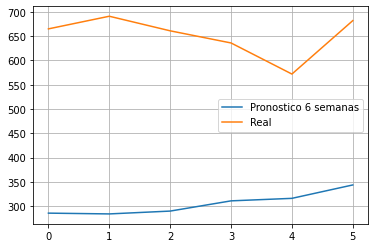

14/14 [==============================] - 0s 12ms/step - loss: 0.0153

['loss']: 1.53%
8 834
Test RMSE: 301.662


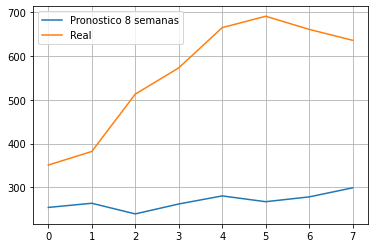

14/14 [==============================] - 1s 12ms/step - loss: 0.0166

['loss']: 1.66%
8 834
Test RMSE: 278.425


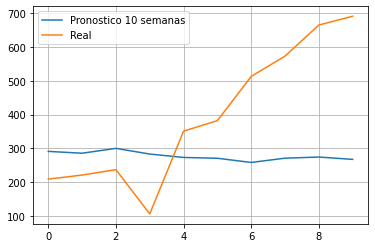

14/14 [==============================] - 0s 12ms/step - loss: 0.0155

['loss']: 1.55%
8 834
Test RMSE: 222.397


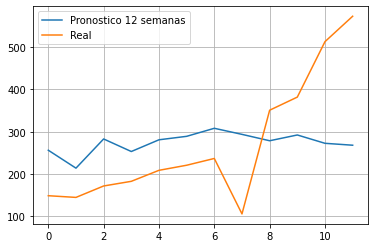

In [12]:

# Err_cnn_lstm = []
# for i in range(semanas_pronostico):
Er1 = cnn_lstm_win(6)
Er1 = cnn_lstm_win(8)
Er1 = cnn_lstm_win(10)
Er1 = cnn_lstm_win(12)
    #Err_cnn_lstm = np.append(Err_cnn_lstm, Er1)
# print(Err_cnn_lstm)
# plt.plot(Err_cnn_lstm,label="Error")
# plt.title('Error CNN-LSTM')
# plt.xlabel('Número de semanas pronosticadas')
# plt.ylabel('Error cuadrado medio')
# plt.legend()
# plt.grid()
# plt.show()

In [19]:
def perceptron_win(shift=2):
    

    x_train,x_test,x_pron,y_train,y_test,y_test_inv, y_pron, y_pron_inv = data_gen(shift, cnn=False, mix=False)

    seed = 3
    np.random.seed(seed)
    tf.random.set_seed(seed)
    epochs = 200
    batch = 1
    lr = 0.0003
    adam = optimizers.Adam(lr)


    model_MLP1 = Sequential()

    model_MLP1.add(Dense(70,  activation='relu'))
    model_MLP1.add(Dense(20, activation='relu'))
#     model_MLP1.add(Dense(1,  activation='sigmoid'))

#     model_MLP1.add(Dense(150,  activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros'))
#     model_MLP1.add(Dense(70,  activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros'))
#     model_MLP1.add(Dense(40,  activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros'))
#     model_MLP1.add(Dense(15,  activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros'))
    model_MLP1.add(Dense(shift,  activation='sigmoid'))


    model_MLP1.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])


    MLP1_history = model_MLP1.fit(x_train, y_train, epochs=epochs, batch_size=batch,validation_data=(x_test, y_test),verbose=0, shuffle=False)

    scores = model_MLP1.evaluate(x_train, y_train)
    print("\n%s: %.2f%%" % (model_MLP1.metrics_names[0], scores[0]*100))
    print("\n%s: %.2f%%" % (model_MLP1.metrics_names[1], scores[1]*100))


    yhatP = model_MLP1.predict(x_pron)
    

    
    inv_yhatP = Reescala(yhatP, np.amin(valy), np.amax(valy))

    inv_yhatP_mlp1 = np.reshape(inv_yhatP, (inv_yhatP.shape[0],shift)) 
    
    inv_yhatP = np.reshape(inv_yhatP, (inv_yhatP.shape[0],shift))
    plt.clf()
    plt.plot(inv_yhatP[:,0], label='Pronostico '+str(shift)+' semanas')
    plt.plot(y_pron_inv[:,0], label='Real')
    plt.legend()
    plt.grid()
    plt.show()
    
#     Error = mean_squared_error(inv_yhatP, y_pron_inv, squared=False)
#     print('Error cuadratico medio: ', Error)
#     print('\n\n\n+-------------------------------------------------------------------------------------------+\n')
    return 


14/14 [==============================] - 0s 1ms/step - loss: 0.0305 - mean_squared_error: 0.0293    

loss: 3.05%

mean_squared_error: 2.93%


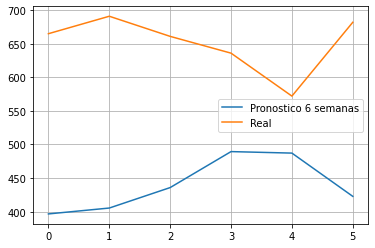

14/14 [==============================] - 0s 1ms/step - loss: 0.0288 - mean_squared_error: 0.0278    

loss: 2.88%

mean_squared_error: 2.78%


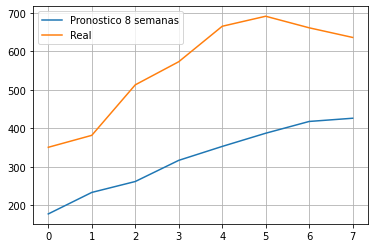

14/14 [==============================] - 0s 2ms/step - loss: 0.0282 - mean_squared_error: 0.0275    

loss: 2.82%

mean_squared_error: 2.75%


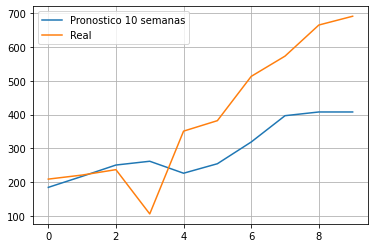

14/14 [==============================] - 0s 1ms/step - loss: 0.0263 - mean_squared_error: 0.0260    

loss: 2.63%

mean_squared_error: 2.60%


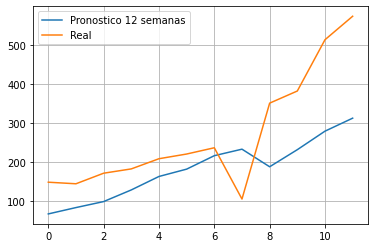

In [20]:
# Err_mlp = []
# for i in range(semanas_pronostico):
Er1 = perceptron_win(6)
Er1 = perceptron_win(8)
Er1 = perceptron_win(10)
Er1 = perceptron_win(12)
#     Err_mlp = np.append(Err_mlp, Er1)
# print(Err_mlp)
# plt.plot(Err_mlp,label="Error")
# plt.title('Error MLP')
# plt.xlabel('Número de semanas pronosticadas')
# plt.ylabel('Error cuadrado medio')
# plt.legend()
# plt.grid()
# plt.show()

In [15]:
def lstm_win(shift=2):
    
    x_train,x_test,x_pron,y_train,y_test,y_test_inv, y_pron, y_pron_inv = data_gen(shift, cnn=False,mix=False)

    seed = 3
    np.random.seed(seed)

    epochs = 200
    batch = 1
    lr = 0.00003
    adam = optimizers.Adam(lr)

    tf.random.set_seed(seed)

    model_LSTM1 = Sequential()
    model_LSTM1.add(LSTM(100, input_shape=(x_train.shape[1], x_train.shape[2])))
    model_LSTM1.add(Dense(shift))
    model_LSTM1.compile(loss='mae', optimizer='adam')
    # fit network
    LSTM1_history = model_LSTM1.fit(x_train, y_train, epochs=epochs, batch_size=batch, validation_data=(x_test, y_test), verbose=0, shuffle=False)

    scores = model_LSTM1.evaluate(x_train, y_train)
    print("\n%s: %.4f%%" % (model_LSTM1.metrics_names[0], scores*100))


    yhatP = model_LSTM1.predict(x_pron)
    inv_yhatLSTM = Reescala(yhatP, np.amin(valy), np.amax(valy))

    inv_yhat_LSTM1 = np.reshape(inv_yhatLSTM, (inv_yhatLSTM.shape[0],shift))

    rmseP = sqrt(mean_squared_error(y_pron_inv, inv_yhat_LSTM1))
    print('Test RMSE: %.3f' % rmseP)
    

    inv_yhatLSTM = np.reshape(inv_yhatLSTM, (inv_yhatLSTM.shape[0],shift))
    plt.clf()
    plt.plot(inv_yhat_LSTM1[:,0], label='Pronostico '+str(shift)+' semanas')
    plt.plot(y_pron_inv[:,0], label='Real')
    plt.legend()
    plt.grid()
    plt.show()
    

#     Error = mean_squared_error(inv_yhat_LSTM1, y_pron_inv, squared=False)
#     print('Error cuadratico medio: ', Error)
#     print('\n\n\n+-------------------------------------------------------------------------------------------+\n')
    return

14/14 [==============================] - 6s 3ms/step - loss: 0.0612

loss: 6.1211%
Test RMSE: 147.364


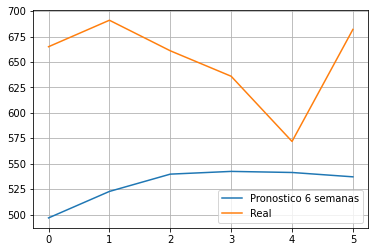

14/14 [==============================] - 6s 3ms/step - loss: 0.0534

loss: 5.3358%
Test RMSE: 278.802


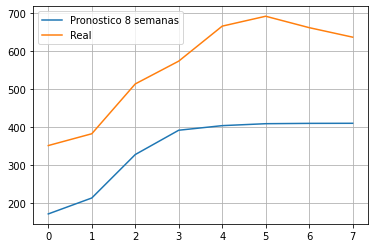

14/14 [==============================] - 5s 3ms/step - loss: 0.0490

loss: 4.9014%
Test RMSE: 214.487


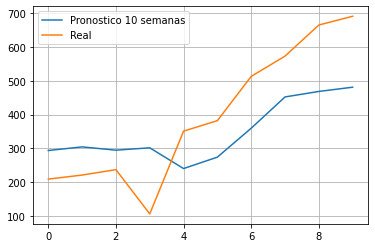

14/14 [==============================] - 3s 2ms/step - loss: 0.0640

loss: 6.3980%
Test RMSE: 189.801


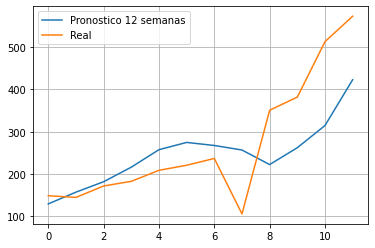

In [16]:
# Err_lstm = []
# for i in range(semanas_pronostico):
Er1 = lstm_win(6)
Er1 = lstm_win(8)
Er1 = lstm_win(10)
Er1 = lstm_win(12)
#     Err_lstm = np.append(Err_lstm, Er1)
# print(Err_lstm)
# plt.plot(Err_lstm,label="Error")
# plt.title('Error LSTM')
# plt.xlabel('Número de semanas pronosticadas')
# plt.ylabel('Error cuadrado medio')
# plt.legend()
# plt.grid()
# plt.show()

In [17]:
def cnn_win(shift=2):
    
    x_train,x_test,x_pron,y_train,y_test,y_test_inv, y_pron, y_pron_inv = data_gen(shift, cnn=True, mix=False)

    seed = 3
    np.random.seed(seed)

    epochs = 200
    batch = 1
    lr = 0.00003
    adam = optimizers.Adam(lr)

    tf.random.set_seed(seed)
    



    model_CNN = Sequential()
    model_CNN.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
    model_CNN.add(MaxPooling1D(pool_size=2))
    model_CNN.add(Flatten())
    model_CNN.add(Dense(75, activation='relu'))
    model_CNN.add(Dense(shift))
    model_CNN.compile(loss='mse', optimizer = 'adam')
    # fit network
    CNN_history = model_CNN.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, verbose=0)


    scores = model_CNN.evaluate(x_train, y_train)
    print("\n%s: %.2f%%" % (model_CNN.metrics_names, scores*100))


    # Prediccion con datos de Pronostico - Modelo CNN
    yhatP_CNN = model_CNN.predict(x_pron)
    yhatP_CNN = np.reshape(yhatP_CNN, (yhatP_CNN.shape[0],shift))
    inv_yhatP_CNN = Reescala(yhatP_CNN, np.amin(valy), np.amax(valy))


    rmseCNN = sqrt(mean_squared_error(y_pron_inv, inv_yhatP_CNN))
    print('Test RMSE: %.3f' % rmseCNN)
    
    inv_yhatP_CNN = np.reshape(inv_yhatP_CNN, (inv_yhatP_CNN.shape[0],shift))
    plt.clf()
    plt.plot(inv_yhatP_CNN[:,0], label='Pronostico '+str(shift)+' semanas')
    plt.plot(y_pron_inv[:,0], label='Real')
    plt.legend()
    plt.grid()
    plt.show()
    
#     Error = mean_squared_error(inv_yhatP_CNN, y_pron_inv, squared=False)
#     print('Error cuadratico medio: ', Error)
#     print('\n\n\n+-------------------------------------------------------------------------------------------+\n')
    return

14/14 [==============================] - 0s 4ms/step - loss: 3.6865e-04

['loss']: 0.04%
Test RMSE: 192.049


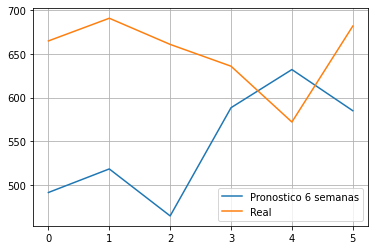

14/14 [==============================] - 0s 4ms/step - loss: 4.2554e-04

['loss']: 0.04%
Test RMSE: 195.476


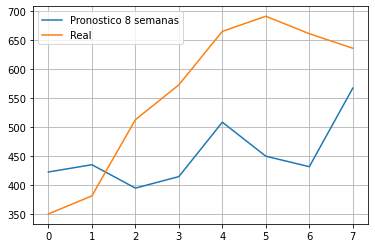

14/14 [==============================] - 0s 4ms/step - loss: 4.7521e-04

['loss']: 0.05%
Test RMSE: 207.043


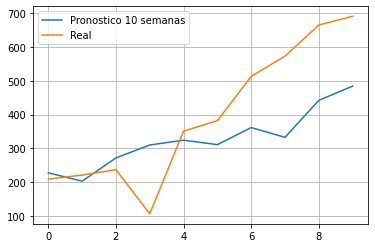

14/14 [==============================] - 0s 3ms/step - loss: 5.8092e-04

['loss']: 0.06%
Test RMSE: 217.008


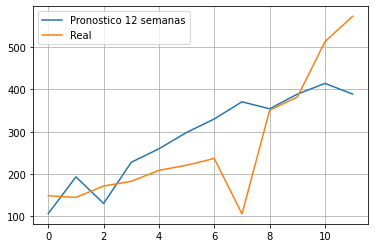

In [18]:

# Err_cnn = []
# for i in range(semanas_pronostico):
#     Er1 = cnn_win(i+1)
#     Err_cnn = np.append(Err_cnn, Er1)
# print(Err_cnn)
# plt.plot(Err_cnn,label="Error")
# plt.title('Error CNN')
# plt.xlabel('Número de semanas pronosticadas')
# plt.ylabel('Error cuadrado medio')
# plt.legend()
# plt.grid()
# plt.show()
Er1 = cnn_win(6)
Er1 = cnn_win(8)
Er1 = cnn_win(10)
Er1 = cnn_win(12)